# Extracting Transistor Electrical Characteristics

In this notebook, we seek to extract

- maximum storage tempurature
- minimum storage tempurature
- polarity
- maximum collector emitter voltage
- maximum emitter base voltage
- maximum collector current
- total device dissipation
- minimum dc gain



In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import os
import sys
import logging

# To allow importing from the general utils
sys.path.insert(0, "..")

# Configure logging for Fonduer
logging.basicConfig(
    stream=sys.stdout,
    format="[%(asctime)s][%(levelname)s] %(name)s:%(lineno)s - %(message)s",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

# See https://docs.python.org/3/library/os.html#os.cpu_count
PARALLEL = len(os.sched_getaffinity(0)) // 2
COMPONENT = "transistors"
conn_string = "postgresql://localhost:5432/" + COMPONENT
logger.info(f"PARALLEL: {PARALLEL}")

[2019-02-11 18:58:27,272][INFO] __main__:23 - PARALLEL: 2


In [2]:
# If you've run this before, set FIRST_TIME to False to save time
FIRST_TIME = True

In [3]:
from fonduer import Meta

session = Meta.init(conn_string).Session()

[2019-02-11 18:58:27,489][INFO] fonduer.meta:86 - Connecting user:None to localhost:5432/transistors
[2019-02-11 18:58:28,984][INFO] fonduer.meta:110 - Initializing the storage schema


In [4]:
from utils import parse_dataset

docs, train_docs, dev_docs, test_docs = parse_dataset(
    session, first_time=FIRST_TIME, parallel=PARALLEL, max_docs=75
)
logger.info(f"# of train Documents: {len(train_docs)}")
logger.info(f"# of dev Documents: {len(dev_docs)}")
logger.info(f"# of test Documents: {len(test_docs)}")

[2019-02-11 18:58:29,829][INFO] utils.utils:39 - Parsing dev...
[2019-02-11 18:58:33,813][INFO] fonduer.utils.udf:57 - Running UDF...



[2019-02-11 19:03:20,569][INFO] utils.utils:39 - Parsing test...
[2019-02-11 19:03:25,246][INFO] fonduer.utils.udf:57 - Running UDF...



[2019-02-11 19:09:32,168][INFO] utils.utils:39 - Parsing train...
[2019-02-11 19:09:36,073][INFO] fonduer.utils.udf:57 - Running UDF...



[2019-02-11 19:15:10,816][INFO] __main__:6 - # of train Documents: 75
[2019-02-11 19:15:10,817][INFO] __main__:7 - # of dev Documents: 75
[2019-02-11 19:15:10,817][INFO] __main__:8 - # of test Documents: 75


In [5]:
from fonduer.parser.models import Document, Section, Paragraph, Sentence, Figure

logger.info(f"Documents: {session.query(Document).count()}")
logger.info(f"Sections: {session.query(Section).count()}")
logger.info(f"Paragraphs: {session.query(Paragraph).count()}")
logger.info(f"Sentences: {session.query(Sentence).count()}")
logger.info(f"Figures: {session.query(Figure).count()}")

[2019-02-11 19:15:10,838][INFO] __main__:3 - Documents: 225
[2019-02-11 19:15:10,843][INFO] __main__:4 - Sections: 225
[2019-02-11 19:15:10,948][INFO] __main__:5 - Paragraphs: 100744
[2019-02-11 19:15:11,097][INFO] __main__:6 - Sentences: 103730
[2019-02-11 19:15:11,138][INFO] __main__:7 - Figures: 6009


# Phase 2: Mention Extraction, Candidate Extraction Multimodal Featurization

Given the unified data model from Phase 1, `Fonduer` extracts relation
candidates based on user-provided **matchers** and **throttlers**. Then,
`Fonduer` leverages the multimodality information captured in the unified data
model to provide multimodal features for each candidate.

## 2.1 Mention Extraction

The first step is to extract **mentions** from our corpus. A `mention` is the
type of object which makes up a `candidate`. For example, if we wanted to
extract pairs of transistor part numbers and their corresponding maximum
storage temperatures, the transistor part number would be one `mention` while
the temperature value would be another. These `mention`s are then combined to
create `candidates`, where our task is to predict which `candidates` are true
in the associated document.

We first start by defining and naming our two `mention`s:

In [6]:
from fonduer.candidates.models import mention_subclass

Part = mention_subclass("Part")
StgTempMin = mention_subclass("StgTempMin")
StgTempMax = mention_subclass("StgTempMax")
Polarity = mention_subclass("Polarity")
CeVMax = mention_subclass("CeVMax")

In [7]:
from transistor_matchers import get_matcher
stg_temp_min_matcher = get_matcher("stg_temp_min")
stg_temp_max_matcher = get_matcher("stg_temp_max")
polarity_matcher = get_matcher("polarity")
ce_v_max_matcher = get_matcher("ce_v_max")
part_matcher = get_matcher("part")

These two matchers define each entity in our relation schema.

### Define a Mention's `MentionSpace`

Next, in order to define the "space" of all mentions that are even considered
from the document, we need to define a `MentionSpace` for each component of the
relation we wish to extract. Fonduer provides a default `MentionSpace` for you
to use, but you can also extend the default `MentionSpace` depending on your
needs.

In the case of transistor part numbers, the `MentionSpace` can be quite complex
due to the need to handle implicit part numbers that are implied in text like
"BC546A/B/C...BC548A/B/C", which refers to 9 unique part numbers. To handle
these, we consider all n-grams up to 3 words long.

In contrast, the `MentionSpace` for temperature values is simpler: we only need
to process different Unicode representations of a (`-`), and don't need to look
at more than two words at a time.

When no special preprocessing like this is needed, we could have used the
default `Ngrams` class provided by `fonduer`. For example, if we were looking
to match polarities, which only take the form of "NPN" or "PNP", we could've
used `ngrams = MentionNgrams(n_max=1)`.

In [8]:
from fonduer.candidates import MentionNgrams
from transistor_spaces import MentionNgramsPart, MentionNgramsTemp, MentionNgramsVolt
    
part_ngrams = MentionNgramsPart(parts_by_doc=None, n_max=3)
temp_ngrams = MentionNgramsTemp(n_max=2)
volt_ngrams = MentionNgramsVolt(n_max=1)
polarity_ngrams = MentionNgrams(n_max=1)

### Running Mention Extraction 

Next, we create a `MentionExtractor` to extract the mentions from all of
our documents based on the `MentionSpace` and matchers we defined above.

View the API for the MentionExtractor on [ReadTheDocs](https://fonduer.readthedocs.io/en/latest/user/candidates.html#fonduer.candidates.MentionExtractor).


In [9]:
from fonduer.candidates import MentionExtractor

mention_extractor = MentionExtractor(
    session,
    [Part, StgTempMin, StgTempMax, Polarity, CeVMax],
    [part_ngrams, temp_ngrams, temp_ngrams, polarity_ngrams, volt_ngrams],
    [
        part_matcher,
        stg_temp_min_matcher,
        stg_temp_max_matcher,
        polarity_matcher,
        ce_v_max_matcher,
    ],
)

Then, we run the extractor on all of our documents.

In [10]:
from fonduer.candidates.models import Mention

if FIRST_TIME:
    mention_extractor.apply(docs, parallelism=PARALLEL)

logger.info(f"Total Mentions: {session.query(Mention).count()}")
logger.info(f"Total Part: {session.query(Part).count()}")
logger.info(f"Total StgTempMin: {session.query(StgTempMin).count()}")
logger.info(f"Total StgTempMax: {session.query(StgTempMax).count()}")
logger.info(f"Total Polarity: {session.query(Polarity).count()}")
logger.info(f"Total CeVMax: {session.query(CeVMax).count()}")

[2019-02-11 19:15:11,593][INFO] fonduer.candidates.mentions:460 - Clearing table: part
[2019-02-11 19:15:11,625][INFO] fonduer.candidates.mentions:460 - Clearing table: stg_temp_min
[2019-02-11 19:15:11,627][INFO] fonduer.candidates.mentions:460 - Clearing table: stg_temp_max
[2019-02-11 19:15:11,631][INFO] fonduer.candidates.mentions:460 - Clearing table: polarity
[2019-02-11 19:15:11,633][INFO] fonduer.candidates.mentions:460 - Clearing table: ce_v_max
[2019-02-11 19:15:11,636][INFO] fonduer.utils.udf:57 - Running UDF...



[2019-02-11 19:17:20,141][INFO] __main__:6 - Total Mentions: 11006
[2019-02-11 19:17:20,151][INFO] __main__:7 - Total Part: 4153
[2019-02-11 19:17:20,157][INFO] __main__:8 - Total StgTempMin: 2671
[2019-02-11 19:17:20,163][INFO] __main__:9 - Total StgTempMax: 2671
[2019-02-11 19:17:20,169][INFO] __main__:10 - Total Polarity: 1221
[2019-02-11 19:17:20,174][INFO] __main__:11 - Total CeVMax: 290


## 2.2 Candidate Extraction

Now that we have both defined and extracted the Mentions that can be used to compose Candidates, we are ready to move on to extracting Candidates. Like we did with the Mentions, we first define what each candidate schema looks like. In this example, we create a candidate that is composed of a `Part` and a `Temp` mention as we defined above. We name this candidate "PartTemp".

In [11]:
from fonduer.candidates.models import candidate_subclass

PartStgTempMin = candidate_subclass("PartStgTempMin", [Part, StgTempMin])
PartStgTempMax = candidate_subclass("PartStgTempMax", [Part, StgTempMax])
PartPolarity = candidate_subclass("PartPolarity", [Part, Polarity])
PartCeVMax = candidate_subclass("PartCeVMax", [Part, CeVMax])

### Defining candidate `Throttlers`

Next, we need to define **throttlers**, which allow us to further prune excess candidates and avoid unnecessarily materializing invalid candidates. Throttlers, like matchers, act as hard filters, and should be created to have high precision while maintaining complete recall, if possible.

Here, we create a throttler that discards candidates if they are in the same table, but the part and storage temperature are not vertically or horizontally aligned.

In [12]:
from transistor_throttlers import stg_temp_filter, polarity_filter, ce_v_max_filter

temp_throttler = stg_temp_filter
polarity_throttler = polarity_filter
ce_v_max_throttler = ce_v_max_filter

### Running the `CandidateExtractor`

Now, we have all the component necessary to perform candidate extraction. We have defined the Mentions that compose each candidate and a throttler to prunes away excess candidates. We now can define the `CandidateExtractor` with the candidate subclass and corresponding throttler to use.

View the API for the CandidateExtractor on [ReadTheDocs](https://fonduer.readthedocs.io/en/docstrings/user/candidates.html#fonduer.candidates.CandidateExtractor).

In [13]:
from fonduer.candidates import CandidateExtractor

candidate_extractor = CandidateExtractor(
    session,
    [PartStgTempMin, PartStgTempMax, PartPolarity, PartCeVMax],
    throttlers=[temp_throttler, temp_throttler, polarity_throttler, ce_v_max_throttler],
)

Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [14]:
if FIRST_TIME:
    for i, docs in enumerate([train_docs, dev_docs, test_docs]):
        candidate_extractor.apply(docs, split=i, parallelism=PARALLEL)
        logger.info(
            f"PartStgTempMin in split={i}: "
            f"{session.query(PartStgTempMin).filter(PartStgTempMin.split == i).count()}"
        )
        logger.info(
            f"PartStgTempMax in split={i}: "
            f"{session.query(PartStgTempMax).filter(PartStgTempMax.split == i).count()}"
        )
        logger.info(
            f"PartPolarity in split={i}: "
            f"{session.query(PartPolarity).filter(PartPolarity.split == i).count()}"
        )
        logger.info(
            f"PartCeVMax in split={i}: "
            f"{session.query(PartCeVMax).filter(PartCeVMax.split == i).count()}"
        )


train_cands = candidate_extractor.get_candidates(split = 0)
dev_cands = candidate_extractor.get_candidates(split = 1)
test_cands = candidate_extractor.get_candidates(split = 2)

logger.info(f"Total train candidate: {len(train_cands[0])}")
logger.info(f"Total dev candidate: {len(dev_cands[0])}")
logger.info(f"Total test candidate: {len(test_cands[0])}")

[2019-02-11 19:17:20,347][INFO] fonduer.candidates.candidates:125 - Clearing table part_stg_temp_min (split 0)
[2019-02-11 19:17:20,377][INFO] fonduer.candidates.candidates:125 - Clearing table part_stg_temp_max (split 0)
[2019-02-11 19:17:20,380][INFO] fonduer.candidates.candidates:125 - Clearing table part_polarity (split 0)
[2019-02-11 19:17:20,382][INFO] fonduer.candidates.candidates:125 - Clearing table part_ce_v_max (split 0)
[2019-02-11 19:17:20,385][INFO] fonduer.utils.udf:57 - Running UDF...



[2019-02-11 19:27:09,259][INFO] __main__:5 - PartStgTempMin in split=0: 64442
[2019-02-11 19:27:09,301][INFO] __main__:9 - PartStgTempMax in split=0: 64442
[2019-02-11 19:27:09,335][INFO] __main__:13 - PartPolarity in split=0: 34900
[2019-02-11 19:27:09,363][INFO] __main__:17 - PartCeVMax in split=0: 1406
[2019-02-11 19:27:09,363][INFO] fonduer.candidates.candidates:125 - Clearing table part_stg_temp_min (split 1)
[2019-02-11 19:27:09,366][INFO] fonduer.candidates.candidates:125 - Clearing table part_stg_temp_max (split 1)
[2019-02-11 19:27:09,369][INFO] fonduer.candidates.candidates:125 - Clearing table part_polarity (split 1)
[2019-02-11 19:27:09,372][INFO] fonduer.candidates.candidates:125 - Clearing table part_ce_v_max (split 1)
[2019-02-11 19:27:09,375][INFO] fonduer.utils.udf:57 - Running UDF...



[2019-02-11 19:30:31,628][INFO] __main__:5 - PartStgTempMin in split=1: 23841
[2019-02-11 19:30:31,671][INFO] __main__:9 - PartStgTempMax in split=1: 23841
[2019-02-11 19:30:31,708][INFO] __main__:13 - PartPolarity in split=1: 15338
[2019-02-11 19:30:31,732][INFO] __main__:17 - PartCeVMax in split=1: 3411
[2019-02-11 19:30:31,733][INFO] fonduer.candidates.candidates:125 - Clearing table part_stg_temp_min (split 2)
[2019-02-11 19:30:31,736][INFO] fonduer.candidates.candidates:125 - Clearing table part_stg_temp_max (split 2)
[2019-02-11 19:30:31,739][INFO] fonduer.candidates.candidates:125 - Clearing table part_polarity (split 2)
[2019-02-11 19:30:31,742][INFO] fonduer.candidates.candidates:125 - Clearing table part_ce_v_max (split 2)
[2019-02-11 19:30:31,745][INFO] fonduer.utils.udf:57 - Running UDF...



[2019-02-11 19:31:40,319][INFO] __main__:5 - PartStgTempMin in split=2: 8045
[2019-02-11 19:31:40,345][INFO] __main__:9 - PartStgTempMax in split=2: 8045
[2019-02-11 19:31:40,365][INFO] __main__:13 - PartPolarity in split=2: 5035
[2019-02-11 19:31:40,378][INFO] __main__:17 - PartCeVMax in split=2: 778
[2019-02-11 19:31:45,061][INFO] __main__:26 - Total train candidate: 64442
[2019-02-11 19:31:45,061][INFO] __main__:27 - Total dev candidate: 23841
[2019-02-11 19:31:45,062][INFO] __main__:28 - Total test candidate: 8045


## 2.2 Multimodal Featurization
Unlike dealing with plain unstructured text, `Fonduer` deals with richly formatted data, and consequently featurizes each candidate with a baseline library of multimodal features. 

### Featurize with `Fonduer`'s optimized Postgres Featurizer
We now annotate the candidates in our training, dev, and test sets with features. The `Featurizer` provided by `Fonduer` allows this to be done in parallel to improve performance.

View the API provided by the `Featurizer` on [ReadTheDocs](https://fonduer.readthedocs.io/en/latest/user/features.html#fonduer.features.Featurizer).

In [15]:
from fonduer.features import Featurizer

featurizer = Featurizer(session, [PartStgTempMin, PartStgTempMax, PartPolarity, PartCeVMax])
if FIRST_TIME:
    %time featurizer.apply(split=0, train=True, parallelism=PARALLEL)
    %time featurizer.apply(split=1, parallelism=PARALLEL)
    %time featurizer.apply(split=2, parallelism=PARALLEL)

%time F_train = featurizer.get_feature_matrices(train_cands)
%time F_dev = featurizer.get_feature_matrices(dev_cands)
%time F_test = featurizer.get_feature_matrices(test_cands)

logger.info(f"Train shape: {F_train[0].shape}")
logger.info(f"Test shape: {F_test[0].shape}")
logger.info(f"Dev shape: {F_dev[0].shape}")

[2019-02-11 19:31:48,598][INFO] fonduer.features.featurizer:190 - Clearing Features (split 0)
[2019-02-11 19:31:48,609][INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 4.23 s, sys: 237 ms, total: 4.47 s
Wall time: 8min 15s
[2019-02-11 19:40:01,979][INFO] fonduer.features.featurizer:190 - Clearing Features (split 1)
[2019-02-11 19:40:02,321][INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 2.48 s, sys: 201 ms, total: 2.69 s
Wall time: 3min 13s
[2019-02-11 19:43:13,911][INFO] fonduer.features.featurizer:190 - Clearing Features (split 2)
[2019-02-11 19:43:14,121][INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 1.62 s, sys: 126 ms, total: 1.74 s
Wall time: 1min 20s
CPU times: user 4min 18s, sys: 13.8 s, total: 4min 32s
Wall time: 6min 5s
CPU times: user 1min 42s, sys: 5.14 s, total: 1min 47s
Wall time: 2min 24s
CPU times: user 36.4 s, sys: 1.61 s, total: 38 s
Wall time: 50.2 s
[2019-02-11 19:53:53,640][INFO] __main__:13 - Train shape: (64442, 17705)
[2019-02-11 19:53:53,641][INFO] __main__:14 - Test shape: (8045, 17705)
[2019-02-11 19:53:53,641][INFO] __main__:15 - Dev shape: (23841, 17705)


In [16]:
from transistor_utils import load_transistor_labels
from transistor_lfs import ABSTAIN, TRUE, FALSE

if FIRST_TIME:
    load_transistor_labels(
        session,
        [PartStgTempMin, PartStgTempMax, PartPolarity, PartCeVMax],
        ["stg_temp_min", "stg_temp_max", "polarity", "ce_v_max"],
        annotator_name="gold",
    )

[2019-02-11 19:54:01,195][INFO] transistor_utils:87 - Loading stg_temp_min for <class 'fonduer.candidates.models.candidate.PartStgTempMin'>...
[2019-02-11 19:54:01,269][INFO] transistor_utils:91 - Loading 96328 candidate labels



[2019-02-11 19:56:30,801][INFO] transistor_utils:121 - GoldLabels created: 96328
[2019-02-11 19:56:31,992][INFO] transistor_utils:87 - Loading stg_temp_max for <class 'fonduer.candidates.models.candidate.PartStgTempMax'>...
[2019-02-11 19:56:32,035][INFO] transistor_utils:91 - Loading 192656 candidate labels



[2019-02-11 20:03:00,367][INFO] transistor_utils:121 - GoldLabels created: 96328
[2019-02-11 20:03:01,042][INFO] transistor_utils:87 - Loading polarity for <class 'fonduer.candidates.models.candidate.PartPolarity'>...
[2019-02-11 20:03:01,083][INFO] transistor_utils:91 - Loading 247929 candidate labels



[2019-02-11 20:12:41,742][INFO] transistor_utils:121 - GoldLabels created: 55273
[2019-02-11 20:12:41,840][INFO] transistor_utils:87 - Loading ce_v_max for <class 'fonduer.candidates.models.candidate.PartCeVMax'>...
[2019-02-11 20:12:41,878][INFO] transistor_utils:91 - Loading 253524 candidate labels



[2019-02-11 20:23:39,720][INFO] transistor_utils:121 - GoldLabels created: 5595


In [17]:
from fonduer.supervision import Labeler
from transistor_lfs import (
    stg_temp_min_lfs,
    stg_temp_max_lfs,
    polarity_lfs,
    ce_v_max_lfs,
)

labeler = Labeler(session, [PartStgTempMin, PartStgTempMax, PartPolarity, PartCeVMax])
if FIRST_TIME:
    %time labeler.apply(split=0, lfs=[stg_temp_min_lfs, stg_temp_max_lfs, polarity_lfs, ce_v_max_lfs], train=True, parallelism=PARALLEL)

%time L_train = labeler.get_label_matrices(train_cands)

[2019-02-11 20:23:45,174][INFO] fonduer.supervision.labeler:219 - Clearing Labels (split 0)
[2019-02-11 20:23:45,186][INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 6.07 s, sys: 392 ms, total: 6.46 s
Wall time: 1h 3min 12s
CPU times: user 3min 35s, sys: 9.7 s, total: 3min 44s
Wall time: 4min 54s


In [18]:
L_gold_train = labeler.get_gold_labels(train_cands, annotator='gold')

In [19]:
from metal import analysis

analysis.lf_summary(
    L_train[0],
    lf_names=labeler.get_keys(),
    Y=L_gold_train[0].todense().reshape(-1).tolist()[0],
)

/home/lwhsiao/repos/hack/.venv/lib/python3.6/site-packages/metal/analysis.py:131: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * (X.sum(axis=0) / (L != 0).sum(axis=0) + 1)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LabelKey (LF_both_present),0,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_collector_aligned),1,1,0.034682,0.034682,0.003631,2235,0,1.0
LabelKey (LF_complement_left_row),2,1,0.000155,0.000155,0.000062,10,0,1.0
LabelKey (LF_current_aligned),3,1,0.485103,0.485103,0.017628,31261,0,1.0
LabelKey (LF_negative_number_left),4,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_non_ce_voltages_in_row),5,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_not_temp_relevant),6,1,0.957683,0.957683,0.029965,61715,0,1.0
LabelKey (LF_operating_row),7,2,0.028956,0.028956,0.028956,0,1866,0.0
LabelKey (LF_other_minus_signs_in_row),8,1,0.869123,0.869123,0.019196,56008,0,1.0
LabelKey (LF_part_ce_keywords_in_col_prefix_same_table),9,[],0.000000,0.000000,0.000000,0,0,NaN


In [20]:
analysis.lf_summary(
    L_train[1],
    lf_names=labeler.get_keys(),
    Y=L_gold_train[1].todense().reshape(-1).tolist()[0],
)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LabelKey (LF_both_present),0,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_collector_aligned),1,1,0.034682,0.034682,0.001707,2235,0,1.0
LabelKey (LF_complement_left_row),2,1,0.000155,0.000155,0.000062,10,0,1.0
LabelKey (LF_current_aligned),3,1,0.485103,0.485103,0.005555,31261,0,1.0
LabelKey (LF_negative_number_left),4,2,0.023184,0.023184,0.023184,0,1494,0.0
LabelKey (LF_non_ce_voltages_in_row),5,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_not_temp_relevant),6,1,0.957683,0.957683,0.001893,61715,0,1.0
LabelKey (LF_operating_row),7,2,0.028956,0.028956,0.028956,0,1866,0.0
LabelKey (LF_other_minus_signs_in_row),8,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_part_ce_keywords_in_col_prefix_same_table),9,[],0.000000,0.000000,0.000000,0,0,NaN


In [21]:
analysis.lf_summary(
    L_train[2],
    lf_names=labeler.get_keys(),
    Y=L_gold_train[2].todense().reshape(-1).tolist()[0],
)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LabelKey (LF_both_present),0,1,0.003954,0.001719,0.001719,138,0,1.0
LabelKey (LF_collector_aligned),1,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_complement_left_row),2,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_current_aligned),3,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_negative_number_left),4,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_non_ce_voltages_in_row),5,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_not_temp_relevant),6,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_operating_row),7,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_other_minus_signs_in_row),8,[],0.000000,0.000000,0.000000,0,0,NaN
LabelKey (LF_part_ce_keywords_in_col_prefix_same_table),9,[],0.000000,0.000000,0.000000,0,0,NaN


In [22]:
analysis.lf_summary(
    L_train[3],
    lf_names=labeler.get_keys(),
    Y=L_gold_train[3].todense().reshape(-1).tolist()[0],
)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LabelKey (LF_both_present),0,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_collector_aligned),1,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_complement_left_row),2,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_current_aligned),3,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_negative_number_left),4,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_non_ce_voltages_in_row),5,1,0.099573,0.099573,0.0,140,0,1.000000
LabelKey (LF_not_temp_relevant),6,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_operating_row),7,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_other_minus_signs_in_row),8,[],0.000000,0.000000,0.0,0,0,NaN
LabelKey (LF_part_ce_keywords_in_col_prefix_same_table),9,"[1, 2]",1.000000,0.099573,0.0,1383,23,0.983642


### Fitting the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other. To do so, we use [MeTaL](https://github.com/HazyResearch/metal)'s single-task label model.

In [23]:
from metal.label_model import LabelModel

stg_temp_min_model = LabelModel(k=2)
stg_temp_max_model = LabelModel(k=2)
polarity_model = LabelModel(k=2)
ce_v_max_model = LabelModel(k=2)

%time stg_temp_min_model.train_model(L_train[0], n_epochs=500, print_every=100)
%time stg_temp_max_model.train_model(L_train[1], n_epochs=500, print_every=100)
%time polarity_model.train_model(L_train[2], n_epochs=500, print_every=100)
%time ce_v_max_model.train_model(L_train[3], n_epochs=500, print_every=100)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 8.584
[E:100]	Train Loss: 0.072
[E:200]	Train Loss: 0.042
[E:300]	Train Loss: 0.024
[E:400]	Train Loss: 0.023
[E:499]	Train Loss: 0.023
Finished Training
CPU times: user 792 ms, sys: 21.1 ms, total: 813 ms
Wall time: 843 ms
Computing O...
Estimating \mu...
[E:0]	Train Loss: 7.232
[E:100]	Train Loss: 0.063
[E:200]	Train Loss: 0.035
[E:300]	Train Loss: 0.031
[E:400]	Train Loss: 0.031
[E:499]	Train Loss: 0.031
Finished Training
CPU times: user 777 ms, sys: 29.6 ms, total: 806 ms
Wall time: 804 ms
Computing O...
Estimating \mu...
[E:0]	Train Loss: 0.137
[E:100]	Train Loss: 0.001
[E:200]	Train Loss: 0.000
[E:300]	Train Loss: 0.000
[E:400]	Train Loss: 0.000
[E:499]	Train Loss: 0.000
Finished Training
CPU times: user 759 ms, sys: 8.01 ms, total: 767 ms
Wall time: 766 ms
Computing O...
Estimating \mu...
[E:0]	Train Loss: 0.749
[E:100]	Train Loss: 0.000
[E:200]	Train Loss: 0.000
[E:300]	Train Loss: 0.000
[E:400]	Train Loss: 0.000
[E:499]	Train 

We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [24]:
stg_temp_min_marginals = stg_temp_min_model.predict_proba(L_train[0])
stg_temp_max_marginals = stg_temp_max_model.predict_proba(L_train[1])
polarity_marginals = polarity_model.predict_proba(L_train[2])
ce_v_max_marginals = ce_v_max_model.predict_proba(L_train[3])

We'll look at the distribution of the training marginals:

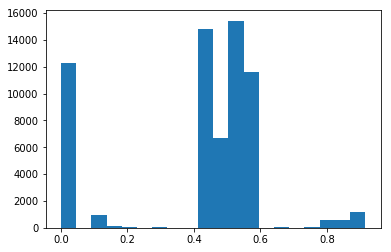

In [25]:
import matplotlib.pyplot as plt
plt.hist(stg_temp_min_marginals[:, TRUE - 1], bins=20)
plt.show()

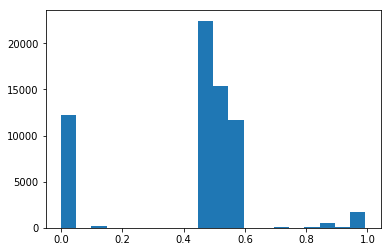

In [26]:
plt.hist(stg_temp_max_marginals[:, TRUE - 1], bins=20)
plt.show()

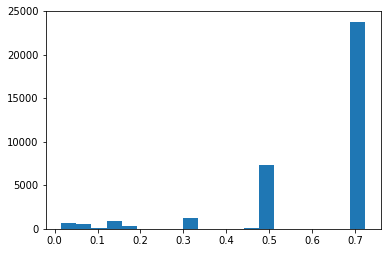

In [27]:
plt.hist(polarity_marginals[:, TRUE - 1], bins=20)
plt.show()

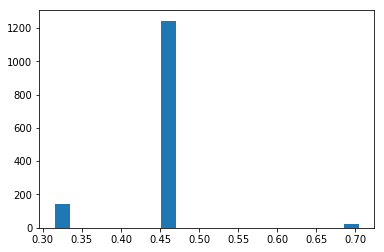

In [28]:
plt.hist(ce_v_max_marginals[:, TRUE - 1], bins=20)
plt.show()

### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [29]:
%time labeler.apply(split=1, lfs=[stg_temp_min_lfs, stg_temp_max_lfs, polarity_lfs, ce_v_max_lfs], parallelism=PARALLEL)

%time L_dev = labeler.get_label_matrices(dev_cands)

[2019-02-11 21:33:34,372][INFO] fonduer.supervision.labeler:219 - Clearing Labels (split 1)
[2019-02-11 21:33:34,507][INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 4.76 s, sys: 656 ms, total: 5.41 s
Wall time: 13min 8s
CPU times: user 1min 28s, sys: 3.85 s, total: 1min 32s
Wall time: 2min


### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!

In fact, it is probably somewhat overfit to this set. However this is fine, since in the next, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).


### Training the Discriminative Model

Now, we'll use the noisy training labels we generated in the last part to train our end extraction model. For this tutorial, we will be training a simple--but fairly effective--logistic regression model.

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. 

In [30]:
from fonduer.learning import LogisticRegression

stg_temp_min_disc_model = LogisticRegression()
stg_temp_max_disc_model = LogisticRegression()
polarity_disc_model = LogisticRegression()
ce_v_max_disc_model = LogisticRegression()

%time stg_temp_min_disc_model.train((train_cands[0], F_train[0]), stg_temp_min_marginals, n_epochs=50, lr=0.001)
%time stg_temp_max_disc_model.train((train_cands[1], F_train[1]), stg_temp_max_marginals, n_epochs=50, lr=0.001)
%time polarity_disc_model.train((train_cands[2], F_train[2]), polarity_marginals, n_epochs=50, lr=0.001)
%time ce_v_max_disc_model.train((train_cands[3], F_train[3]), ce_v_max_marginals, n_epochs=50, lr=0.001)

[2019-02-11 21:48:41,008][INFO] fonduer.learning.classifier:98 - Loading default parameters for Logistic Regression
[2019-02-11 21:48:49,809][INFO] fonduer.learning.classifier:195 - Settings: {'n_epochs': 50, 'lr': 0.001, 'batch_size': 256, 'shuffle': True, 'seed': 1234, 'host_device': 'CPU', 'bias': False, 'input_dim': 17705}
[2019-02-11 21:48:49,810][INFO] fonduer.learning.classifier:213 - [LogisticRegression] Training model
[2019-02-11 21:48:49,811][INFO] fonduer.learning.classifier:215 - [LogisticRegression] n_train=64442 #epochs=50 batch size=256
[2019-02-11 21:50:36,136][INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 1 (106.32s)	Average loss=0.555296
[2019-02-11 21:57:50,510][INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 5 (540.70s)	Average loss=0.542541
[2019-02-11 22:07:23,671][INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 10 (1113.86s)	Average loss=0.542581
[2019-02-11 22:17:38,419][INFO] fonduer.learning.classifier

[2019-02-12 01:27:04,355][INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 45 (99.73s)	Average loss=0.682670
[2019-02-12 01:27:15,430][INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 50 (110.80s)	Average loss=0.682549
[2019-02-12 01:27:15,431][INFO] fonduer.learning.classifier:278 - [LogisticRegression] Training done (110.80s)
CPU times: user 2min 1s, sys: 198 ms, total: 2min 1s
Wall time: 1min 51s


In [31]:
import numpy as np
from transistor_utils import entity_level_f1
import pickle
pickle_file = 'data/parts_by_doc_dict.pkl'
with open(pickle_file, 'rb') as f:
    parts_by_doc = pickle.load(f)

Now, we score using the discriminitive model:

In [32]:
stg_temp_min_test_score = stg_temp_min_disc_model.predict((test_cands[0], F_test[0]), b=0.6, pos_label=TRUE)
stg_temp_min_true_pred = [test_cands[0][_] for _ in np.nditer(np.where(stg_temp_min_test_score == TRUE))]
(TP, FP, FN) = entity_level_f1(
    stg_temp_min_true_pred, "stg_temp_min", test_docs, parts_by_doc=parts_by_doc
)

[2019-02-12 01:27:28,784][INFO] fonduer.learning.classifier:354 - Using positive label class 2 with threshold 0.6
[2019-02-12 01:27:29,031][INFO] transistor_utils:157 - Preparing candidates...



[2019-02-12 01:27:34,258][INFO] transistor_utils:178 - ========================================
[2019-02-12 01:27:34,258][INFO] transistor_utils:179 - Scoring on Entity-Level Gold Data
[2019-02-12 01:27:34,259][INFO] transistor_utils:180 - ========================================
[2019-02-12 01:27:34,259][INFO] transistor_utils:181 - Corpus Precision 0.0
[2019-02-12 01:27:34,260][INFO] transistor_utils:182 - Corpus Recall    0.0
[2019-02-12 01:27:34,261][INFO] transistor_utils:183 - Corpus F1        nan
[2019-02-12 01:27:34,262][INFO] transistor_utils:184 - ----------------------------------------
[2019-02-12 01:27:34,264][INFO] transistor_utils:185 - TP: 0 | FP: 245 | FN: 150
[2019-02-12 01:27:34,265][INFO] transistor_utils:186 - ========================================



In [33]:
stg_temp_max_test_score = stg_temp_max_disc_model.predict((test_cands[1], F_test[1]), b=0.6, pos_label=TRUE)
stg_temp_max_true_pred = [test_cands[1][_] for _ in np.nditer(np.where(stg_temp_max_test_score == TRUE))]
(TP, FP, FN) = entity_level_f1(
    stg_temp_max_true_pred, "stg_temp_max", test_docs, parts_by_doc=parts_by_doc
)

[2019-02-12 01:27:47,390][INFO] fonduer.learning.classifier:354 - Using positive label class 2 with threshold 0.6
[2019-02-12 01:27:47,483][INFO] transistor_utils:157 - Preparing candidates...



[2019-02-12 01:27:50,061][INFO] transistor_utils:178 - ========================================
[2019-02-12 01:27:50,062][INFO] transistor_utils:179 - Scoring on Entity-Level Gold Data
[2019-02-12 01:27:50,062][INFO] transistor_utils:180 - ========================================
[2019-02-12 01:27:50,063][INFO] transistor_utils:181 - Corpus Precision 0.472
[2019-02-12 01:27:50,064][INFO] transistor_utils:182 - Corpus Recall    0.83
[2019-02-12 01:27:50,066][INFO] transistor_utils:183 - Corpus F1        0.602
[2019-02-12 01:27:50,071][INFO] transistor_utils:184 - ----------------------------------------
[2019-02-12 01:27:50,072][INFO] transistor_utils:185 - TP: 127 | FP: 142 | FN: 26
[2019-02-12 01:27:50,076][INFO] transistor_utils:186 - ========================================



In [34]:
polarity_test_score = polarity_disc_model.predict((test_cands[2], F_test[2]), b=0.6, pos_label=TRUE)
polarity_true_pred = [test_cands[2][_] for _ in np.nditer(np.where(polarity_test_score == TRUE))]
(TP, FP, FN) = entity_level_f1(
    polarity_true_pred, "polarity", test_docs, parts_by_doc=parts_by_doc
)

[2019-02-12 01:27:58,335][INFO] fonduer.learning.classifier:354 - Using positive label class 2 with threshold 0.6
[2019-02-12 01:27:58,413][INFO] transistor_utils:157 - Preparing candidates...



[2019-02-12 01:27:59,579][INFO] transistor_utils:178 - ========================================
[2019-02-12 01:27:59,579][INFO] transistor_utils:179 - Scoring on Entity-Level Gold Data
[2019-02-12 01:27:59,580][INFO] transistor_utils:180 - ========================================
[2019-02-12 01:27:59,580][INFO] transistor_utils:181 - Corpus Precision 1.0
[2019-02-12 01:27:59,583][INFO] transistor_utils:182 - Corpus Recall    0.197
[2019-02-12 01:27:59,585][INFO] transistor_utils:183 - Corpus F1        0.33
[2019-02-12 01:27:59,585][INFO] transistor_utils:184 - ----------------------------------------
[2019-02-12 01:27:59,586][INFO] transistor_utils:185 - TP: 44 | FP: 0 | FN: 179
[2019-02-12 01:27:59,587][INFO] transistor_utils:186 - ========================================



In [35]:
ce_v_max_test_score = ce_v_max_disc_model.predict((test_cands[3], F_test[3]), b=0.6, pos_label=TRUE)
ce_v_max_true_pred = [test_cands[3][_] for _ in np.nditer(np.where(ce_v_max_test_score == TRUE))]
(TP, FP, FN) = entity_level_f1(
    ce_v_max_true_pred, "ce_v_max", test_docs, parts_by_doc=parts_by_doc
)

[2019-02-12 01:28:00,863][INFO] fonduer.learning.classifier:354 - Using positive label class 2 with threshold 0.6
[2019-02-12 01:28:00,913][INFO] transistor_utils:157 - Preparing candidates...



[2019-02-12 01:28:00,958][INFO] transistor_utils:178 - ========================================
[2019-02-12 01:28:00,959][INFO] transistor_utils:179 - Scoring on Entity-Level Gold Data
[2019-02-12 01:28:00,960][INFO] transistor_utils:180 - ========================================
[2019-02-12 01:28:00,961][INFO] transistor_utils:181 - Corpus Precision 1.0
[2019-02-12 01:28:00,962][INFO] transistor_utils:182 - Corpus Recall    0.0132
[2019-02-12 01:28:00,963][INFO] transistor_utils:183 - Corpus F1        0.026
[2019-02-12 01:28:00,964][INFO] transistor_utils:184 - ----------------------------------------
[2019-02-12 01:28:00,967][INFO] transistor_utils:185 - TP: 2 | FP: 0 | FN: 150
[2019-02-12 01:28:00,968][INFO] transistor_utils:186 - ========================================



We can see that there are actually only a few documents that are causing us problems. In particular, we see that `BC546-D` is giving us many false positives. So, let's inspect one of those candidates. 

In [36]:
from fonduer.utils.visualizer import Visualizer
from transistor_utils import entity_to_candidates

vis = Visualizer("data/test/pdf")

# Get a list of candidates that match the FN[10] entity
fp_cands = entity_to_candidates(FP[1], test_cands[0])
# Display a candidate
vis.display_candidates([fp_cands[0]])

IndexError: list index out of range